In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
csv_path = "/content/train_text_clean.csv"  # Replace with the correct path
dataset = pd.read_csv(csv_path)

In [3]:
words_list = np.load("wordsList.npy", allow_pickle=True)
word_vectors = np.load("wordVectors.npy")
print(f"Words List Size: {len(words_list)}")
print(f"Word Vectors Shape: {word_vectors.shape}")

Words List Size: 400000
Word Vectors Shape: (400000, 300)


In [4]:
words_list = np.load("wordsList.npy", allow_pickle=True).tolist()  # Use allow_pickle to ensure compatibility
word_vectors = np.load("wordVectors.npy")

In [5]:
# Parameters
max_seq_length = 20  # Maximum sequence length
embedding_dim = word_vectors.shape[1]  # Dimension of word vectors

In [6]:
# Helper function: Convert text to indices
def text_to_indices(text, words_list, max_seq_length):
    tokens = text.strip("[]").replace("'", "").split(", ")
    indices = [words_list.index(word) if word in words_list else 0 for word in tokens]
    if len(indices) > max_seq_length:
        indices = indices[:max_seq_length]
    else:
        indices.extend([0] * (max_seq_length - len(indices)))
    return indices

In [7]:
# Preprocess the dataset
dataset['text_indices'] = dataset['title_author'].apply(lambda x: text_to_indices(x, words_list, max_seq_length))

In [8]:
# Split dataset into train and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [9]:
# Custom Dataset class
class BookDataset(Dataset):
    def __init__(self, data):
        self.texts = torch.tensor(data['text_indices'].tolist(), dtype=torch.long)
        self.labels = torch.tensor(data['category id'].tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [10]:
# Prepare train data loaders
train_dataset = BookDataset(train_data)
val_dataset = BookDataset(val_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
# Prepare test data loaders
test_csv_path = "test_text_clean.csv"  # Replace with your test dataset path
test_dataset = pd.read_csv(test_csv_path)
test_dataset['text_indices'] = test_dataset['title_author'].apply(lambda x: text_to_indices(x, words_list, max_seq_length))
test_dataset = BookDataset(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# Define RNN-LSTM model
class RNNLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(RNNLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return output

In [13]:
# Model parameters
hidden_dim = 256
output_dim = len(dataset['category id'].unique())  # Number of categories
model = RNNLSTM(word_vectors, hidden_dim, output_dim)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

In [14]:
training_losses = []
validation_losses = []
testing_losses = []
epochs = 25
best_val_accuracy = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for texts, labels in train_dataloader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    avg_train_loss = epoch_loss / len(train_dataloader)  # Average loss for the epoch
    training_losses.append(avg_train_loss)  # Append training loss for the epoch

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for texts, labels in val_dataloader:
            predictions = model(texts)
            loss = criterion(predictions, labels)  # Compute validation loss
            val_loss += loss.item()
            _, predicted = torch.max(predictions, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_dataloader)  # Average validation loss for the epoch
    validation_losses.append(avg_val_loss)  # Append validation loss for the epoch

    # Testing phase
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for texts, labels in test_dataloader:
            predictions = model(texts)
            loss = criterion(predictions, labels)  # Compute testing loss
            test_loss += loss.item()
            _, predicted = torch.max(predictions, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total
    avg_test_loss = test_loss / len(test_dataloader)  # Average testing loss for the epoch
    testing_losses.append(avg_test_loss)  # Append testing loss for the epoch

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved.")
    else:
        print("Early stopping triggered.")
        break


Epoch 1/25, Train Loss: 3.0441, Train Accuracy: 0.1131, Validation Loss: 2.4878, Validation Accuracy: 0.2585, Test Loss: 2.4898, Test Accuracy: 0.2618
Best model saved.
Epoch 2/25, Train Loss: 2.3140, Train Accuracy: 0.3263, Validation Loss: 2.0332, Validation Accuracy: 0.4184, Test Loss: 2.0425, Test Accuracy: 0.4095
Best model saved.
Epoch 3/25, Train Loss: 2.0424, Train Accuracy: 0.4208, Validation Loss: 1.8735, Validation Accuracy: 0.4689, Test Loss: 1.9003, Test Accuracy: 0.4596
Best model saved.
Epoch 4/25, Train Loss: 1.9050, Train Accuracy: 0.4649, Validation Loss: 1.8133, Validation Accuracy: 0.4907, Test Loss: 1.8442, Test Accuracy: 0.4816
Best model saved.
Epoch 5/25, Train Loss: 1.8074, Train Accuracy: 0.4914, Validation Loss: 1.7482, Validation Accuracy: 0.5101, Test Loss: 1.7666, Test Accuracy: 0.5059
Best model saved.
Epoch 6/25, Train Loss: 1.7376, Train Accuracy: 0.5114, Validation Loss: 1.7006, Validation Accuracy: 0.5208, Test Loss: 1.7239, Test Accuracy: 0.5178
Best

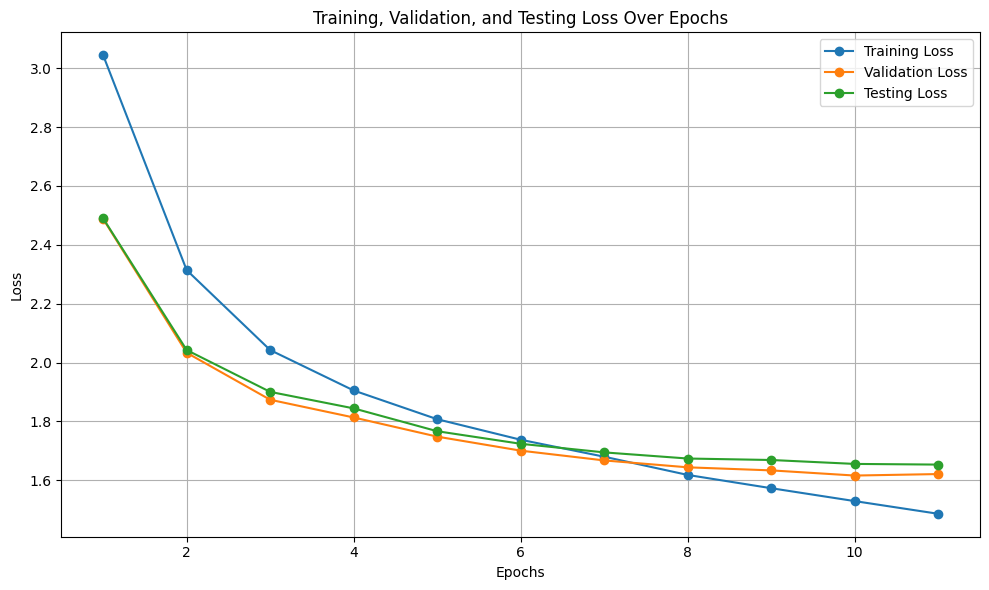

In [16]:
import matplotlib.pyplot as plt

# Generate epochs list based on the length of losses lists
epochs = list(range(1, len(training_losses) + 1))

# Plot training, validation, and testing losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
if validation_losses:  # Only include if you have validation loss
    plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
if testing_losses:  # Only include if you have testing loss
    plt.plot(epochs, testing_losses, label='Testing Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
